

```
len: 500, score:0.8869/threshold:0.007041127953765568
len: 1000, score:0.8901/threshold:0.008917826512169784
[title][abstract] score:0.8931/threshold:0.008531736809345958
BioRedditBERT-uncased: score:0.8920/threshold:0.020030753048508498
cardiffnlp/twitter-roberta-base-emotion: score:0.8830/threshold:0.007230437581947285
epoch: 50, score:0.8975/threshold:0.0075411136520587225
BioRedditBERT-uncased, epoch: 64, score:0.9099/threshold:0.012501978885860918
BioRedditBERT-uncased, epoch: 64, fold: 4, score:0.8993/threshold:0.015931352007776046
BioRedditBERT-uncased, fold: 3, score:0.8981/threshold:0.020341330202952635
```



# TF-roberta-base Baseline [ CV:0.8949 , LB:0.8734 ]

    tensorflow/keras + transformers の notebook です．(pytorch/bert -> Yoshio Sugiyamaさんのフォーラム)
    実行環境は Google Colab です．
    Google Drive 内のディレクトリ構成は以下を想定しています．
    SIGNATE CLI を利用したデータロードとサブミッションをするので，事前にAPI Tokenの取得が必要です．
    GPU/TPUどちらでも実行できますが，今回はTPUを用いて実行しました．

    └── MyDrive
     └── competitioin                     
         ├── signate.json                 # API Token
         └── Signate-Systematic-Review    
             └── notebooks                # notebook 置き場
                 └── baseline_00.ipynb    # 今回の notebook



In [1]:
!cp "/content/drive/MyDrive/Colab Notebooks/signate/medical_treatises/data/train.csv" .
!cp "/content/drive/MyDrive/Colab Notebooks/signate/medical_treatises/data/test.csv" .
!cp "/content/drive/MyDrive/Colab Notebooks/signate/medical_treatises/data/sample_submit.csv" .

# Config

In [2]:
class Config:
    name_v1 = "tf-roberta-base"
    # model = "roberta-base"
    # model = "cardiffnlp/twitter-roberta-base-emotion"
    # model = "lordtt13/COVID-SciBERT"
    model = "cambridgeltl/BioRedditBERT-uncased"
    # model = "bert-large-uncased-whole-word-masking-finetuned-squad"
    # model = "jakelever/coronabert"
    max_length = 1000
    lr = 0.00002
    weight_decay = 1e-5
    n_fold = 5 
    # n_fold = 3 
    epochs = 32
    train_batch_size = 64
    steps_per_epochs = 30
    seeds = [2021]
    target_col = "judgement"
    text_col = "text"  # title + abst
    valid_batch_size = 64
    test_batch_size = 64
    class_weight = None
    submit = True
    debug = False

if Config.debug:
    Config.epochs = 1
    Config.n_fold = 2

# SetUp

In [3]:
import os
import shutil
from requests import get

# from google.colab import drive, files
# drive.mount('/content/drive')  # drive をマウント

# ! pip install --quiet signate
! pip install --quiet transformers
! pip install --quiet tensorflow-addons

# os.makedirs("/root/.signate", exist_ok=True)  # API token 用のディレクトリを作成
# token_path = "/content/drive/MyDrive/competitioin/signate.json"  # token の path
# shutil.copy(token_path, "/root/.signate")  # tokenを"/root/.signate"にコピー

# DRIVE = "/content/drive/MyDrive/competitioin/Signate-Systematic-Review"  # Drive のパス
# EXP = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'][:-6]  # notebook の名前を取得
# INPUT = os.path.join(DRIVE, "input")
# OUTPUT = os.path.join(DRIVE, "output")

INPUT = './'
OUTPUT = './'
OUTPUT_EXP = './'
OUTPUT_EXP_MODEL = './'
OUTPUT_EXP_PREDS = './'
OUTPUT_EXP_FIG = './'
SUBMISSION = './'

# OUTPUT_EXP = os.path.join(OUTPUT, EXP)
# OUTPUT_EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
# OUTPUT_EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")
# OUTPUT_EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
# SUBMISSION = os.path.join(DRIVE, "submission")

# if not os.path.isdir(INPUT):  # 初回時にのみデータをINPUTフォルダにロード
#     os.makedirs(INPUT, exist_ok=True)
#     ! signate download --competition-id=471 --path=$INPUT

# 実験ごとのフォルダを作成
# dirs = [INPUT, OUTPUT, OUTPUT_EXP, SUBMISSION, OUTPUT_EXP_MODEL, OUTPUT_EXP_PREDS, OUTPUT_EXP_FIG]
# for d in dirs:
#     os.makedirs(d, exist_ok=True)


     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 895 kB 59.3 MB/s 
     |████████████████████████████████| 3.3 MB 58.1 MB/s 
     |████████████████████████████████| 636 kB 48.8 MB/s 
     |████████████████████████████████| 109 kB 51.8 MB/s 
     |████████████████████████████████| 546 kB 69.1 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


# Library

In [4]:
import logging
import datetime
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import fbeta_score
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from scipy.optimize import minimize, minimize_scalar

from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow_addons as tfa

import transformers
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification, AutoModel

# Utils

In [5]:
class Logger:
    """log を残す用のクラス"""
    def __init__(self, path):
        self.general_logger = logging.getLogger(path)
        stream_handler = logging.StreamHandler()
        file_general_handler = logging.FileHandler(os.path.join(path, 'Experiment.log'))
        if len(self.general_logger.handlers) == 0:
            self.general_logger.addHandler(stream_handler)
            self.general_logger.addHandler(file_general_handler)
            self.general_logger.setLevel(logging.INFO)

    def info(self, message):
        # display time
        self.general_logger.info('[{}] - {}'.format(self.now_string(), message))

    @staticmethod
    def now_string():
        return str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


In [6]:
warnings.filterwarnings("ignore")  # ignore warnings
logger = Logger(OUTPUT_EXP)  # set logger 

# TPU setting
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', TPU.cluster_spec().as_dict()['worker'])
except ValueError:
    TPU = None
    print('INFO: Not connected to a TPU runtime')

Running on TPU  ['10.73.204.242:8470']


# Model

In [7]:
def build_auto_model():
    """TFAutoModel"""
    transformer = TFAutoModel.from_pretrained(Config.model)
    input_word_ids = tf.keras.layers.Input(shape=(Config.max_length, ), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(Config.max_length, ), dtype=tf.int32, name='attention_mask')

    x = transformer(input_word_ids, attention_mask=attention_mask)
    x = x[0][:, 0, :]  # cls

    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=[input_word_ids, attention_mask],
                                  outputs=[output])

    optimizer = tfa.optimizers.AdamW(lr=Config.lr, weight_decay=Config.weight_decay)
    model.compile(optimizer = optimizer,
                  loss = [tf.keras.losses.BinaryCrossentropy()],  
                  metrics = ["accuracy"]) 
    return model

# Funcs

In [8]:
def opt_fbeta_threshold(y_true, y_pred):
    """fbeta score計算時のthresholdを最適化"""
    def opt_(x): 
        return -fbeta_score(y_true, y_pred >= x, beta=7)
    result = minimize(opt_, x0=np.array([0.1]), method='Powell')
    best_threshold = result['x'].item()
    return best_threshold


def metrics(y_true, y_pred):
    """fbeta(beta=7)の閾値最適化評価関数"""
    bt = opt_fbeta_threshold(y_true, y_pred)
    print(f"bt:{bt}")
    score = fbeta_score(y_true, y_pred >= bt, beta=7)
    return score


def skf(train, n_splits, random_state):
    """層化KFoldのインデックスのリストを作成"""
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    return list(skf.split(train, train[Config.target_col]))


def encode_texts(texts, tokenizer, max_length):
    """text encoding"""
    encoded_dict = tokenizer.batch_encode_plus(
        texts,
        padding = 'max_length',
        truncation = True,
        max_length = max_length,
    )
    return dict(encoded_dict)


def get_dataset(X, y=None, dataset="test"):
    """データをtf.Datasetの形式に変更"""
    if dataset=="train":
        train_dataset = (
            tf.data.Dataset
            .from_tensor_slices((X, y))
            .shuffle(2048)
            .batch(Config.train_batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
            )
        if Config.steps_per_epochs is not None:
            train_dataset = train_dataset.repeat()

        return train_dataset

    elif dataset=="valid":
        valid_dataset = (
            tf.data.Dataset
            .from_tensor_slices((X, y))
            .batch(Config.valid_batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )
        return valid_dataset
    
    elif dataset=="test":
        test_dataset = (
            tf.data.Dataset
            .from_tensor_slices(X)
            .batch(Config.test_batch_size)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )
        return test_dataset


def get_model_and_tokenizer():
    """model&tokenizer を取得 (TPU ok)"""
    if TPU:
        tf.config.experimental_connect_to_cluster(TPU)
        tf.tpu.experimental.initialize_tpu_system(TPU)
        tpu_strategy = tf.distribute.experimental.TPUStrategy(TPU)
        with tpu_strategy.scope():
            model = build_auto_model()
    else:
        model = build_auto_model()

    tokenizer = AutoTokenizer.from_pretrained(Config.model)
    return model, tokenizer


def get_class_weight(target, weight):
    """class weights の作成"""
    if weight == "balanced":
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(target),
            y=target)
        class_weights = dict(enumerate(class_weights))
    elif weight is None:
        class_weights = None
    else:
        # ex) weight = {0:0.2, 1:0.98}
        class_weights = weight
    
    return class_weights


def training_v1(train_df, valid_df, model, tokenizer, filepath):
    """training 用の関数"""
    tr_text = encode_texts(texts=train_df[Config.text_col].tolist(), tokenizer=tokenizer, max_length=Config.max_length)
    va_text = encode_texts(texts=valid_df[Config.text_col].tolist(), tokenizer=tokenizer, max_length=Config.max_length)
    tr_dataset = get_dataset(X=tr_text, y=train_df[Config.target_col].values, dataset="train")
    va_dataset = get_dataset(X=va_text, y=valid_df[Config.target_col].values, dataset="valid")

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath, 
        moniter="val_loss", 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True,
        mode="min")
    
    model.fit(tr_dataset, 
              epochs=Config.epochs, 
              verbose=1, 
              callbacks=[checkpoint],
              validation_data=va_dataset, 
              steps_per_epoch=Config.steps_per_epochs,
              class_weight=get_class_weight(train_df[Config.target_col], weight=Config.class_weight))


def inference_v1(test_df, model, tokenizer, filepath):
    """推論用の関数"""
    model.load_weights(filepath)
    te_text = encode_texts(texts=test_df[Config.text_col].tolist(), tokenizer=tokenizer, max_length=Config.max_length)
    te_dataset = get_dataset(X=te_text, y=None, dataset="test")
    preds = model.predict(te_dataset)
    return preds.reshape(-1)


def train_cv_v1(train, cv, metrics, name, dir):
    """cross validationの実行関数 (train)"""

    oof = np.zeros(len(train))
    for i_fold, (tr_idx, va_idx) in enumerate(cv):
        K.clear_session()
        model, tokenizer = get_model_and_tokenizer()

        tr_df, va_df = train.iloc[tr_idx].reset_index(), train.iloc[va_idx].reset_index()
        filepath = os.path.join(dir, f"{name}_fold{i_fold+1}.h5")

        if not os.path.isfile(filepath):  # 学習済みモデルがあればtrainingしない
            training_v1(tr_df, va_df, model, tokenizer, filepath)
        
        preds = inference_v1(va_df, model, tokenizer, filepath)

        score = metrics(np.array(va_df[Config.target_col]), preds)
        logger.info(f"{name}_fold{i_fold+1} >>> val socre:{score:.4f}")
        oof[va_idx] = preds
    
    score = metrics(np.array(train[Config.target_col]), oof)
    logger.info(f"{name} >>> val score:{score:.4f}")
    return oof


def predict_cv_v1(test, name, dir):
    """cross validationの実行関数 (test)"""
    preds_fold = []
    for i_fold in range(Config.n_fold):
        model, tokenizer = get_model_and_tokenizer()

        filepath = os.path.join(dir, f"{name}_fold{i_fold+1}.h5")
        preds = inference_v1(test, model, tokenizer, filepath)
        preds_fold.append(preds)

        logger.info(f"{name}_fold{i_fold+1} inference")
    
    preds = np.mean(preds_fold, axis=0)
    return preds


def visualize_confusion_matrix(
        y_true,
        pred_label,
        height=.6,
        labels=None):
    """混合行列をプロット 
    (https://www.guruguru.science/competitions/11/discussions/2fb11851-67d0-4e96-a4b1-5629b944f363/)"""
    
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    plt.show()
    return fig

# Main

In [9]:
!pip install texthero

     |████████████████████████████████| 1.5 MB 8.0 MB/s 
     |████████████████████████████████| 235 kB 41.0 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [10]:
import texthero as hero

def main():
    # load data
    train = pd.read_csv(os.path.join(INPUT, "train.csv"))
    test = pd.read_csv(os.path.join(INPUT, "test.csv"))

    # hero
    # train.title = hero.clean(train.title)
    # train.abstract = hero.clean(train.abstract)
    # test.title = hero.clean(test.title)
    # test.abstract = hero.clean(test.abstract)

    if Config.debug:
        train = train.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)
        test = test.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)

    # preprocess
    train["text"] = train["title"] + " " + train["abstract"].fillna("")
    test["text"] = test["title"] + " " + test["abstract"].fillna("")

    # training
    oof_df = pd.DataFrame()
    for seed in Config.seeds:
        name = f"{Config.name_v1}-{seed}"
        oof = train_cv_v1(train, 
                        cv=skf(train, n_splits=Config.n_fold, random_state=seed),
                        metrics=metrics, 
                        name=name, 
                        dir=OUTPUT_EXP_MODEL)
        oof_df[name] = oof

    oof_df.to_csv(os.path.join(OUTPUT_EXP_PREDS, "oof.csv"), index=False)  # oof 予測値(prob)を保存

    y_true = train[Config.target_col]
    y_pred = oof_df.mean(axis=1)

    best_threshold = opt_fbeta_threshold(y_true.values, y_pred.values)
    oof_score = fbeta_score(y_true, y_pred >= best_threshold, beta=7)
    comments = f"score:{oof_score:.4f}/threshold:{best_threshold}"  # 最終的なスコアと閾値 (スペースがあるとsubmit時のコメントエラーが出る)
    logger.info(comments)

    fig = visualize_confusion_matrix(y_true, y_pred>=best_threshold)  # 混合行列を表示&save
    fig.savefig(os.path.join(OUTPUT_EXP_FIG, "cm.png"), dpi=300)

    # inference
    preds_df = pd.DataFrame()
    for seed in Config.seeds:
        name = f"{Config.name_v1}-{seed}"
        preds = predict_cv_v1(test, name, dir=OUTPUT_EXP_MODEL)
        preds_df[name] = preds

    preds_df.to_csv(os.path.join(OUTPUT_EXP_PREDS, "preds.csv"), index=False)  # test予測値(prob)を保存

    # submit
    if Config.submit:
        sub_df = pd.read_csv(os.path.join(INPUT, "sample_submit.csv"), header=None)
        sub_df.columns = ["id", "judgement"]

        preds = preds_df.mean(axis=1)
        
        # filepath = os.path.join(SUBMISSION, f"{EXP}.csv")
        # sub_df.to_csv(filepath, index=False, header=False)
        sub_df["judgement"] = preds.values
        sub_df.to_csv('sub_prob_007.csv', index=False, header=False)
        sub_df["judgement"] = (preds.values >= best_threshold) * 1
        sub_df.to_csv('sub_007.csv', index=False, header=False)
        
        # signate api を使ってsubmit
        # ! signate submit --competition-id=471 $filepath --note $comments

    # inference2
    preds_df = pd.DataFrame()
    for seed in Config.seeds:
        name = f"{Config.name_v1}-{seed}"
        preds = predict_cv_v1(train, name, dir=OUTPUT_EXP_MODEL)
        preds_df[name] = preds

    preds = preds_df.mean(axis=1)
    train['pred'] = preds
    train[['id', 'pred']].to_csv('pred_train_007.csv', index=False)
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Epoch 1/32


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>]


30/30 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9573

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>]


30/30 [==============================] - 156s 2s/step - loss: 0.1271 - accuracy: 0.9573 - val_loss: 0.1115 - val_accuracy: 0.9768

Epoch 00001: val_loss improved from inf to 0.11151, saving model to ./tf-roberta-base-2021_fold1.h5
Epoch 2/32
30/30 [==============================] - 34s 1s/step - loss: 0.0997 - accuracy: 0.9771 - val_loss: 0.1050 - val_accuracy: 0.9768

Epoch 00002: val_loss improved from 0.11151 to 0.10497, saving model to ./tf-roberta-base-2021_fold1.h5
Epoch 3/32
30/30 [==============================] - 34s 1s/step - loss: 0.0925 - accuracy: 0.9771 - val_loss: 0.0805 - val_accuracy: 0.9779

Epoch 00003: val_loss improved from 0.10497 to 0.08046, saving model to ./tf-roberta-base-2021_fold1.h5
Epoch 4/32
30/30 [==============================] - 34s 1s/step - loss: 0.0827 - accuracy: 0.9734 - val_loss: 0.0762 - val_accuracy: 0.9775

Epoch 00004: val_loss improved from 0.08046 to 0.07624, saving model to ./tf-roberta-base-2021_fold1.h5
Epoch 5/32
30/30 [================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 00:43:13] - tf-roberta-base-2021_fold1 >>> val socre:0.8582
INFO:./:[2021-10-06 00:43:13] - tf-roberta-base-2021_fold1 >>> val socre:0.8582


bt:0.01737780018880934
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/32


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>]


30/30 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9448

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>]


30/30 [==============================] - 161s 2s/step - loss: 0.1717 - accuracy: 0.9448 - val_loss: 0.1073 - val_accuracy: 0.9768

Epoch 00001: val_loss improved from inf to 0.10725, saving model to ./tf-roberta-base-2021_fold2.h5
Epoch 2/32
30/30 [==============================] - 34s 1s/step - loss: 0.1053 - accuracy: 0.9771 - val_loss: 0.1022 - val_accuracy: 0.9768

Epoch 00002: val_loss improved from 0.10725 to 0.10215, saving model to ./tf-roberta-base-2021_fold2.h5
Epoch 3/32
30/30 [==============================] - 34s 1s/step - loss: 0.0972 - accuracy: 0.9776 - val_loss: 0.0925 - val_accuracy: 0.9768

Epoch 00003: val_loss improved from 0.10215 to 0.09245, saving model to ./tf-roberta-base-2021_fold2.h5
Epoch 4/32
30/30 [==============================] - 34s 1s/step - loss: 0.0919 - accuracy: 0.9771 - val_loss: 0.0879 - val_accuracy: 0.9768

Epoch 00004: val_loss improved from 0.09245 to 0.08794, saving model to ./tf-roberta-base-2021_fold2.h5
Epoch 5/32
30/30 [================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 01:11:56] - tf-roberta-base-2021_fold2 >>> val socre:0.9221
INFO:./:[2021-10-06 01:11:56] - tf-roberta-base-2021_fold2 >>> val socre:0.9221


bt:0.006812815382818517
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/32


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>]


30/30 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9802

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>]


30/30 [==============================] - 163s 2s/step - loss: 0.1207 - accuracy: 0.9802 - val_loss: 0.1081 - val_accuracy: 0.9768

Epoch 00001: val_loss improved from inf to 0.10805, saving model to ./tf-roberta-base-2021_fold3.h5
Epoch 2/32
30/30 [==============================] - 36s 1s/step - loss: 0.0958 - accuracy: 0.9781 - val_loss: 0.0878 - val_accuracy: 0.9768

Epoch 00002: val_loss improved from 0.10805 to 0.08782, saving model to ./tf-roberta-base-2021_fold3.h5
Epoch 3/32
30/30 [==============================] - 35s 1s/step - loss: 0.0741 - accuracy: 0.9797 - val_loss: 0.0683 - val_accuracy: 0.9814

Epoch 00003: val_loss improved from 0.08782 to 0.06833, saving model to ./tf-roberta-base-2021_fold3.h5
Epoch 4/32
30/30 [==============================] - 34s 1s/step - loss: 0.0746 - accuracy: 0.9776 - val_loss: 0.0727 - val_accuracy: 0.9784

Epoch 00004: val_loss did not improve from 0.06833
Epoch 5/32
30/30 [==============================] - 34s 1s/step - loss: 0.0548 - accura

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 01:40:43] - tf-roberta-base-2021_fold3 >>> val socre:0.8939
INFO:./:[2021-10-06 01:40:43] - tf-roberta-base-2021_fold3 >>> val socre:0.8939


bt:0.0022745732155508157
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/32


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>]


30/30 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9568

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>]


30/30 [==============================] - 160s 2s/step - loss: 0.1382 - accuracy: 0.9568 - val_loss: 0.1112 - val_accuracy: 0.9766

Epoch 00001: val_loss improved from inf to 0.11125, saving model to ./tf-roberta-base-2021_fold4.h5
Epoch 2/32
30/30 [==============================] - 34s 1s/step - loss: 0.1163 - accuracy: 0.9745 - val_loss: 0.1021 - val_accuracy: 0.9766

Epoch 00002: val_loss improved from 0.11125 to 0.10212, saving model to ./tf-roberta-base-2021_fold4.h5
Epoch 3/32
30/30 [==============================] - 34s 1s/step - loss: 0.1096 - accuracy: 0.9734 - val_loss: 0.0861 - val_accuracy: 0.9766

Epoch 00003: val_loss improved from 0.10212 to 0.08614, saving model to ./tf-roberta-base-2021_fold4.h5
Epoch 4/32
30/30 [==============================] - 34s 1s/step - loss: 0.0765 - accuracy: 0.9755 - val_loss: 0.0707 - val_accuracy: 0.9801

Epoch 00004: val_loss improved from 0.08614 to 0.07067, saving model to ./tf-roberta-base-2021_fold4.h5
Epoch 5/32
30/30 [================

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 02:09:26] - tf-roberta-base-2021_fold4 >>> val socre:0.8967
INFO:./:[2021-10-06 02:09:26] - tf-roberta-base-2021_fold4 >>> val socre:0.8967


bt:0.0040062584183598446
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/32


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1000) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=int64>]


30/30 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9641

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int64>]


30/30 [==============================] - 163s 2s/step - loss: 0.1414 - accuracy: 0.9641 - val_loss: 0.1101 - val_accuracy: 0.9766

Epoch 00001: val_loss improved from inf to 0.11007, saving model to ./tf-roberta-base-2021_fold5.h5
Epoch 2/32
30/30 [==============================] - 35s 1s/step - loss: 0.0990 - accuracy: 0.9792 - val_loss: 0.1119 - val_accuracy: 0.9766

Epoch 00002: val_loss did not improve from 0.11007
Epoch 3/32
30/30 [==============================] - 34s 1s/step - loss: 0.1007 - accuracy: 0.9781 - val_loss: 0.0831 - val_accuracy: 0.9766

Epoch 00003: val_loss improved from 0.11007 to 0.08305, saving model to ./tf-roberta-base-2021_fold5.h5
Epoch 4/32
30/30 [==============================] - 34s 1s/step - loss: 0.0899 - accuracy: 0.9760 - val_loss: 0.0797 - val_accuracy: 0.9742

Epoch 00004: val_loss improved from 0.08305 to 0.07973, saving model to ./tf-roberta-base-2021_fold5.h5
Epoch 5/32
30/30 [==============================] - 34s 1s/step - loss: 0.0547 - accura

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 02:38:16] - tf-roberta-base-2021_fold5 >>> val socre:0.9355
INFO:./:[2021-10-06 02:38:16] - tf-roberta-base-2021_fold5 >>> val socre:0.9355


bt:0.008725569122290179


[2021-10-06 02:38:17] - tf-roberta-base-2021 >>> val score:0.8907
INFO:./:[2021-10-06 02:38:17] - tf-roberta-base-2021 >>> val score:0.8907


bt:0.008176589974614873


[2021-10-06 02:38:18] - score:0.8907/threshold:0.008176589974614873
INFO:./:[2021-10-06 02:38:18] - score:0.8907/threshold:0.008176589974614873


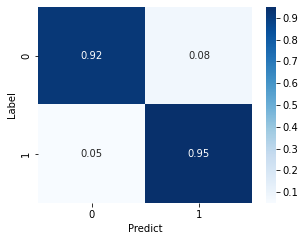

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 02:47:40] - tf-roberta-base-2021_fold1 inference
INFO:./:[2021-10-06 02:47:40] - tf-roberta-base-2021_fold1 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 02:56:55] - tf-roberta-base-2021_fold2 inference
INFO:./:[2021-10-06 02:56:55] - tf-roberta-base-2021_fold2 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 03:06:11] - tf-roberta-base-2021_fold3 inference
INFO:./:[2021-10-06 03:06:11] - tf-roberta-base-2021_fold3 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 03:15:31] - tf-roberta-base-2021_fold4 inference
INFO:./:[2021-10-06 03:15:31] - tf-roberta-base-2021_fold4 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 03:25:41] - tf-roberta-base-2021_fold5 inference
INFO:./:[2021-10-06 03:25:41] - tf-roberta-base-2021_fold5 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 03:32:48] - tf-roberta-base-2021_fold1 inference
INFO:./:[2021-10-06 03:32:48] - tf-roberta-base-2021_fold1 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 03:39:23] - tf-roberta-base-2021_fold2 inference
INFO:./:[2021-10-06 03:39:23] - tf-roberta-base-2021_fold2 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 03:46:25] - tf-roberta-base-2021_fold3 inference
INFO:./:[2021-10-06 03:46:25] - tf-roberta-base-2021_fold3 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 03:53:08] - tf-roberta-base-2021_fold4 inference
INFO:./:[2021-10-06 03:53:08] - tf-roberta-base-2021_fold4 inference


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.204.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 1000) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 1000) dtype=int32>]
[2021-10-06 04:00:07] - tf-roberta-base-2021_fold5 inference
INFO:./:[2021-10-06 04:00:07] - tf-roberta-base-2021_fold5 inference


In [11]:
if __name__ == "__main__":
    main()

In [13]:
!cp ./sub_prob_007.csv "/content/drive/MyDrive/Colab Notebooks/signate/medical_treatises/data/01/sub_prob_007.csv"
!cp ./sub_007.csv "/content/drive/MyDrive/Colab Notebooks/signate/medical_treatises/data/01/sub_007.csv"
!cp ./pred_train_007.csv "/content/drive/MyDrive/Colab Notebooks/signate/medical_treatises/data/01/pred_train_007.csv"

!cp ./tf-roberta-base-2021_fold1.h5 "/content/drive/MyDrive/Colab Notebooks/signate/medical_treatises/data/01/007_fold0_best.h5"
!cp ./tf-roberta-base-2021_fold2.h5 "/content/drive/MyDrive/Colab Notebooks/signate/medical_treatises/data/01/007_fold1_best.h5"
!cp ./tf-roberta-base-2021_fold3.h5 "/content/drive/MyDrive/Colab Notebooks/signate/medical_treatises/data/01/007_fold2_best.h5"
!cp ./tf-roberta-base-2021_fold4.h5 "/content/drive/MyDrive/Colab Notebooks/signate/medical_treatises/data/01/007_fold3_best.h5"
!cp ./tf-roberta-base-2021_fold5.h5 "/content/drive/MyDrive/Colab Notebooks/signate/medical_treatises/data/01/007_fold4_best.h5"